In [2]:
from io import StringIO
import boto3
import pandas as pd
import os

pd.set_option('display.max_columns', 50)

In [3]:
aws_access_key_id = os.getenv('AWS_access_key')
aws_secret_access_key = os.getenv('AWS_secret_access_key')

In [4]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """
    Reads a CSV file from an S3 bucket and returns its contents as a pandas DataFrame.

    Args:
        bucket (str): The name of the S3 bucket where the file is stored.
        path (str): The path or prefix within the bucket where the file is located.
        filename (str): The name of the file to be read.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the content of the CSV file.

    Raises:
        botocore.exceptions.ClientError: If there is an error accessing the S3 bucket or file.
        UnicodeDecodeError: If the file cannot be decoded as UTF-8.
        pd.errors.EmptyDataError: If the file is empty or cannot be parsed as CSV.
    """
    s3 = boto3.client('s3', aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key)
    
    full_path = f'{path}{filename}'

    object = s3.get_object(Bucket = bucket, Key = full_path)
    object = object['Body'].read().decode('utf-8')
    output_df = pd.read_csv(StringIO(object))

    return output_df

In [5]:
s3 = boto3.client('s3', aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key)
bucket = 'cubix-chicago-taxi-ld'

community_areas_path = 'transformed_data/community_areas/'
company_path = 'transformed_data/company/'
date_path = 'transformed_data/date/'
payment_type_path = 'transformed_data/payment_type/'
taxi_trips_path = 'transformed_data/taxi_trips/'
weather_path = 'transformed_data/weather/'

In [6]:
community_areas = read_csv_from_s3(bucket = bucket, path = community_areas_path, filename = 'community_areas_master.csv')
company = read_csv_from_s3(bucket = bucket, path = company_path, filename = 'company_master.csv')
date = read_csv_from_s3(bucket = bucket, path = date_path, filename = 'date_dimension.csv')
payment_type = read_csv_from_s3(bucket = bucket, path = payment_type_path, filename = 'payment_type_master.csv')

In [7]:
trips_list = []
weather_list = []

In [8]:
for file in s3.list_objects(Bucket = bucket, Prefix = taxi_trips_path)['Contents']:
    taxi_trip_key = file['Key']

    if taxi_trip_key.split('/')[-1].strip() != '':
        if taxi_trip_key.split('.')[1] == 'csv':

            filename = taxi_trip_key.split('/')[-1]
            trip = read_csv_from_s3(bucket = bucket, path = taxi_trips_path, filename = filename)

            trips_list.append(trip)
            print(f'{filename} has been added.')


taxi_2025-01-18.csv has been added.
taxi_2025-01-19.csv has been added.
taxi_2025-01-20.csv has been added.
taxi_2025-01-21.csv has been added.
taxi_2025-01-22.csv has been added.
taxi_2025-01-23.csv has been added.
taxi_2025-01-24.csv has been added.
taxi_2025-01-25.csv has been added.
taxi_2025-01-26.csv has been added.
taxi_2025-01-27.csv has been added.
taxi_2025-01-28.csv has been added.
taxi_2025-01-29.csv has been added.
taxi_2025-01-30.csv has been added.
taxi_2025-01-31.csv has been added.
taxi_2025-02-01.csv has been added.
taxi_2025-02-02.csv has been added.
taxi_2025-02-03.csv has been added.
taxi_2025-02-04.csv has been added.
taxi_2025-02-05.csv has been added.
taxi_2025-02-06.csv has been added.
taxi_2025-02-07.csv has been added.
taxi_2025-02-08.csv has been added.
taxi_2025-02-09.csv has been added.


In [9]:
trips = pd.concat(trips_list, ignore_index = True)

In [10]:
trips.shape

(287945, 20)

In [11]:
for file in s3.list_objects(Bucket = bucket, Prefix = weather_path)['Contents']:
    weather_key = file['Key']

    if weather_key.split('/')[-1].strip() != '':
        if weather_key.split('.')[1] == 'csv':

            filename = weather_key.split('/')[-1]
            weather_daily = read_csv_from_s3(bucket = bucket, path = weather_path, filename = filename)

            weather_list.append(weather_daily)
            print(f'{filename} has been added.')


weather_2025-01-18.csv has been added.
weather_2025-01-19.csv has been added.
weather_2025-01-20.csv has been added.
weather_2025-01-21.csv has been added.
weather_2025-01-22.csv has been added.
weather_2025-01-23.csv has been added.
weather_2025-01-24.csv has been added.
weather_2025-01-25.csv has been added.
weather_2025-01-26.csv has been added.
weather_2025-01-27.csv has been added.
weather_2025-01-28.csv has been added.
weather_2025-01-29.csv has been added.
weather_2025-01-30.csv has been added.
weather_2025-01-31.csv has been added.
weather_2025-02-01.csv has been added.
weather_2025-02-02.csv has been added.
weather_2025-02-03.csv has been added.
weather_2025-02-04.csv has been added.
weather_2025-02-05.csv has been added.
weather_2025-02-06.csv has been added.
weather_2025-02-07.csv has been added.
weather_2025-02-08.csv has been added.
weather_2025-02-09.csv has been added.


In [12]:
weather = pd.concat(weather_list, ignore_index = True)

In [13]:
# join all the dataframes together

trips_full = pd.merge(trips, weather, left_on = 'datetime_for_weather', right_on = 'datetime', how = 'inner')
trips_full = trips_full.drop(columns = ['datetime'])

In [14]:
trips_full = pd.merge(trips_full, company, left_on = 'company_id', right_on = 'company_id', how = 'inner')
trips_full = trips_full.drop(columns = ['company_id'])

In [15]:
trips_full = pd.merge(trips_full, payment_type, left_on = 'payment_type_id', right_on = 'payment_type_id', how = 'inner')
trips_full = trips_full.drop(columns = ['payment_type_id'])

In [16]:
trips_full = pd.merge(trips_full, community_areas, left_on = 'pickup_community_area_id', right_on = 'area_code', how = 'inner')
trips_full = trips_full.drop(columns = ['pickup_community_area_id', 'area_code'])
trips_full.rename(columns = {'community_name':'pickup_community_area_name'}, inplace = True)

In [17]:
trips_full = pd.merge(trips_full, community_areas, left_on = 'dropoff_community_area_id', right_on = 'area_code', how = 'inner')
trips_full = trips_full.drop(columns = ['dropoff_community_area_id', 'area_code'])
trips_full.rename(columns = {'community_name':'dropoff_community_area_name'}, inplace = True)

In [18]:
date['date'] = pd.to_datetime(date['date'])
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'])

trips_full['trip_start_date'] = trips_full['trip_start_timestamp'].dt.date
trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'])

In [19]:
trips_full = pd.merge(trips_full, date, left_on = 'trip_start_date', right_on = 'date', how = 'inner')
trips_full = trips_full.drop(columns = ['date'])

In [20]:
trips_full.head(2)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,tempretaure,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,day_of_week,is_weekend
0,0706835645a030fb56452671b41ed76f0eabd4dc,2f8c51760f8358b29119959a9a4864d3d320e18a642b59...,2025-01-18 23:45:00,2025-01-18T23:45:00.000,492,0.58,9.50,2.83,0.0,0.0,12.83,41.899602,-87.633308,41.901207,-87.676356,2025-01-18 23:00:00,-4.5,11.5,0.0,0.0,Flash Cab,Mobile,Near North Side,West Town,2025-01-18,2025,1,18,6,True
1,ede0ad083099d1f42ddbf58886b360842758ac93,791d74df896226a452a8e223e2ec9fa0df7d80bb7ca180...,2025-01-18 23:45:00,2025-01-19T00:15:00.000,1009,3.41,13.78,2.87,0.0,0.0,17.15,41.874005,-87.663518,41.944227,-87.655998,2025-01-18 23:00:00,-4.5,11.5,0.0,0.0,Tac - Checker Cab Dispatch,Mobile,Near West Side,Lake View,2025-01-18,2025,1,18,6,True


## VIZUALIZATIONS

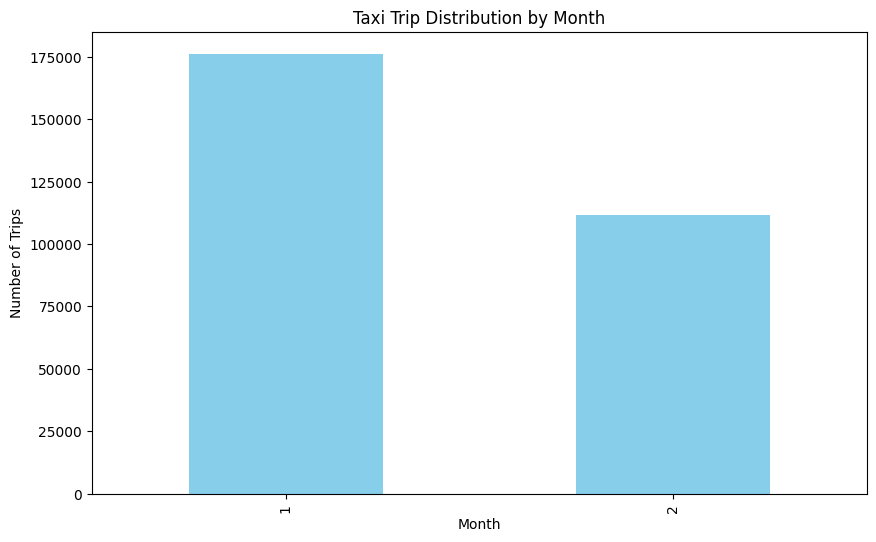

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

trips_full.groupby('month')['trip_id'].count().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Taxi Trip Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_16240\1762888302.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='trip_total', data=trips_full, estimator='mean', ci=None)


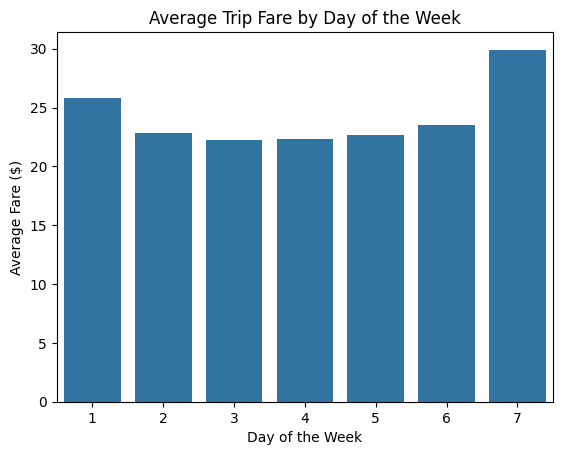

In [22]:
sns.barplot(x='day_of_week', y='trip_total', data=trips_full, estimator='mean', ci=None)
plt.title('Average Trip Fare by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Fare ($)')
plt.show()


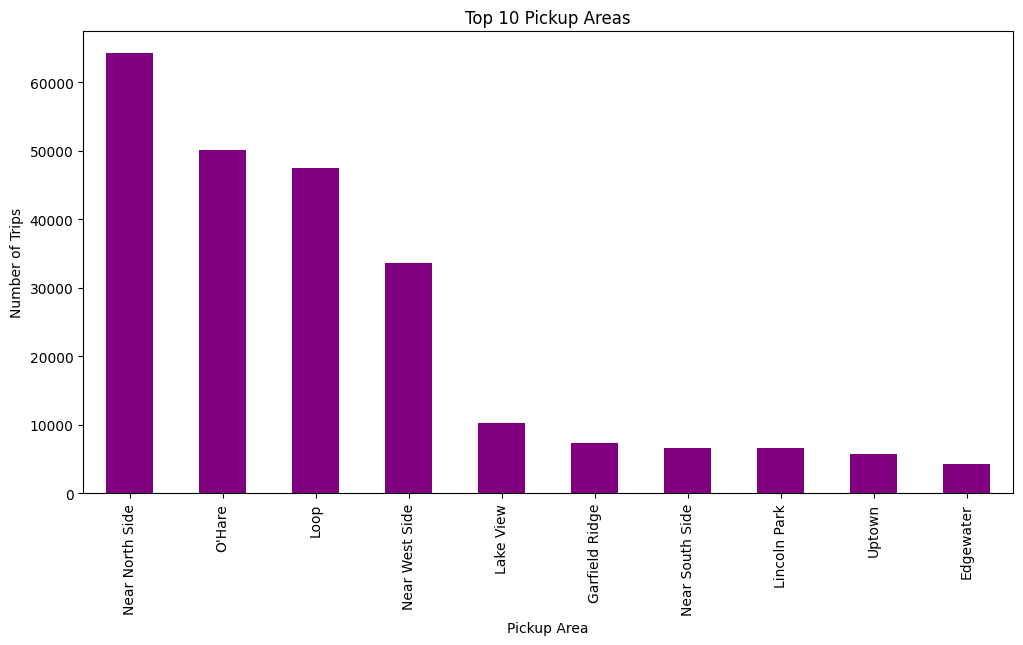

In [24]:
trips_full['pickup_community_area_name'].value_counts().head(10).plot(kind='bar', color='purple', figsize=(12, 6))
plt.title('Top 10 Pickup Areas')
plt.xlabel('Pickup Area')
plt.ylabel('Number of Trips')
plt.show()


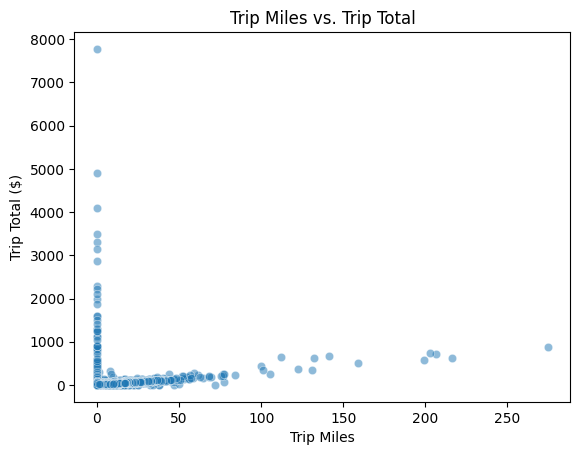

In [25]:
sns.scatterplot(x='trip_miles', y='trip_total', data=trips_full, alpha=0.5)
plt.title('Trip Miles vs. Trip Total')
plt.xlabel('Trip Miles')
plt.ylabel('Trip Total ($)')
plt.show()


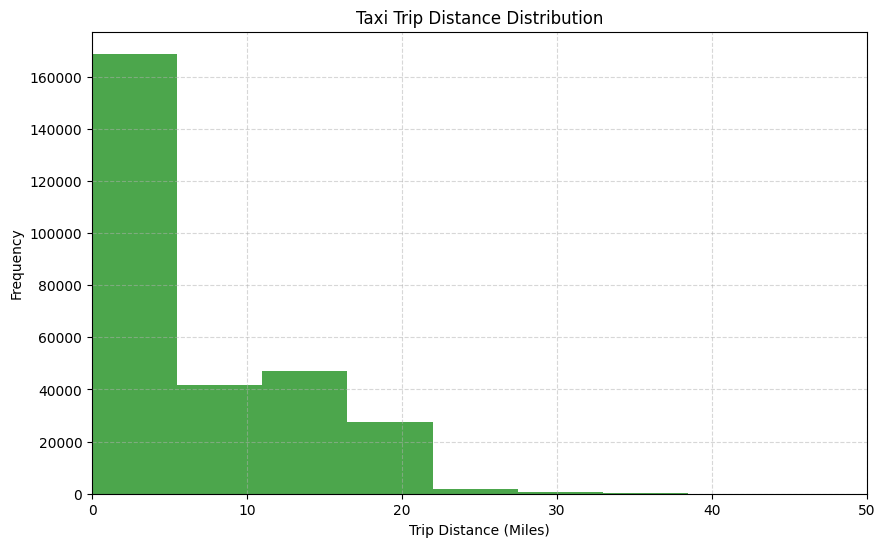

In [27]:
# Histogram of taxi trip distances with axis limit
plt.figure(figsize=(10, 6))
plt.hist(trips_full['trip_miles'], bins=50, color='green', alpha=0.7)
plt.title('Taxi Trip Distance Distribution')
plt.xlabel('Trip Distance (Miles)')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Limit the x-axis from 0 to 50 miles
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



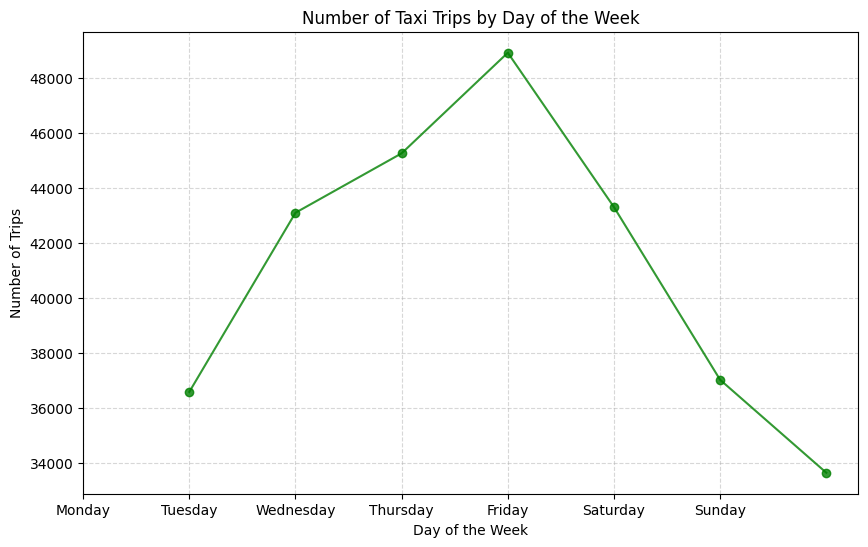

In [30]:
# Grouping the data by day of the week and counting the trips
weekly_trips = trips_full.groupby('day_of_week')['trip_id'].count()

# Sorting the days to appear in order (assuming day_of_week is numeric: 0=Monday, ..., 6=Sunday)
weekly_trips = weekly_trips.sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(weekly_trips.index, weekly_trips.values, marker='o', color='green', linestyle='-', alpha=0.8)
plt.title('Number of Taxi Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])  # Custom labels
plt.show()


